 # PUBG Finish Placement Prediction
 
**final aim**: to build a model to predict final ***winPlacePer ***


> ## Outline: 

1.  EDA including univariate, bivariate Analysis
2. Feature Engineering 
3. Outlier Handling
4. Model Training and Evaluation










In [120]:
%matplotlib inline
%pylab inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
print(os.listdir("../input"))
import xgboost
import warnings
warnings.filterwarnings(action='ignore')

Populating the interactive namespace from numpy and matplotlib
['train_V2.csv', 'test_V2.csv', 'sample_submission_V2.csv']


# Resetting the datatypes

**The Size of the DataSet is quite big almost 4.5mn rows in Training Data which is causing time and memory issues.**

One of the solution is optimising the datatypes. Let's see how much it can help.

 

In [121]:
# Memory saving function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [122]:
df_train = pd.read_csv('../input/train_V2.csv')
df = reduce_mem_usage(df_train)
df.info()

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 288.39 MB
Decreased by 70.7%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int8
boosts             int8
damageDealt        float16
DBNOs              int8
headshotKills      int8
heals              int8
killPlace          int8
killPoints         int16
kills              int8
killStreaks        int8
longestKill        float16
matchDuration      int16
matchType          object
maxPlace           int8
numGroups          int8
rankPoints         int16
revives            int8
rideDistance       float16
roadKills          int8
swimDistance       float16
teamKills          int8
vehicleDestroys    int8
walkDistance       float16
weaponsAcquired    int16
winPoints          int16
winPlacePerc       float16
dtypes: float16(6), int16(5), int8(14), object(4)
memory

**Memory usage of dataframe is 983.90 MB**

**Memory usage after optimization is: 288.39 MB**

**Decreased by 70.7%**

In [123]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

> ## Finding Co-relation between different variables using Pearson's Coefficient

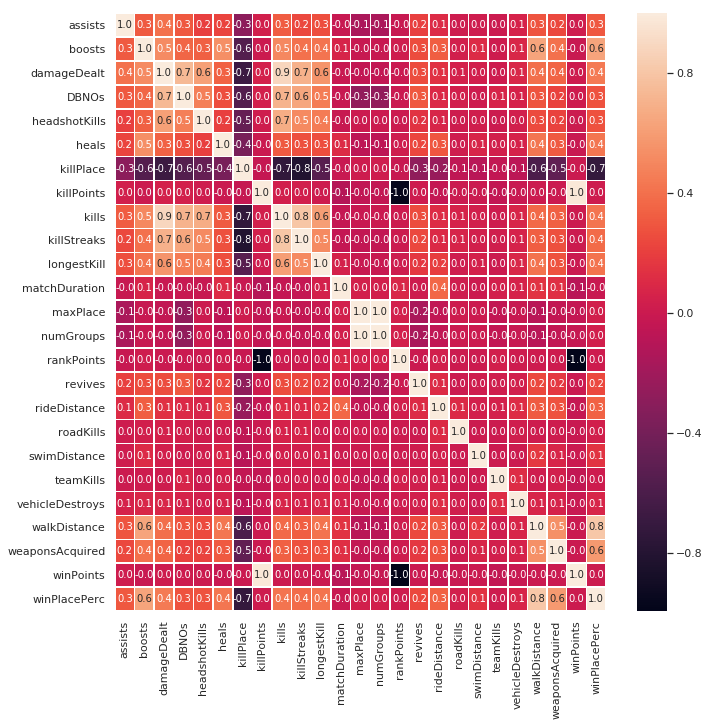

In [124]:
f,ax = plt.subplots(figsize=(11,11))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

> **In terms of the target variable (winPlacePerc), there are a few variables high medium to high correlation. The highest positive correlation is walkDistance and the highest negative the killPlace.**


In [127]:
#importing other dependencies
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
from sklearn import metrics
from scipy.cluster import hierarchy as hc
from pdpbox import pdp
from plotnine import *
from fastai.imports import *
from fastai.structured import *

In [128]:
df.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4446966.00,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4446966.0,4.446966e+06,4.446966e+06,4446966.000,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,NaN,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,NaN,1.579506e+03,4.450467e+01,4.300759e+01,8.920105e+02,1.646590e-01,NaN,3.496091e-03,NaN,2.386841e-02,7.918208e-03,NaN,3.660488e+00,6.064601e+02,NaN
std,5.885731e-01,1.715794e+00,NaN,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,NaN,2.587399e+02,2.382811e+01,2.328949e+01,7.366478e+02,4.721671e-01,NaN,7.337297e-02,NaN,1.673935e-01,9.261157e-02,NaN,2.456544e+00,7.397004e+02,0.000000e+00
min,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,155.125,2.000000e+00,0.000000e+00,1.999512e-01
50%,0.000000e+00,0.000000e+00,84.25,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.443000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,685.500,3.000000e+00,0.000000e+00,4.582520e-01
75%,0.000000e+00,2.000000e+00,186.00,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,2.131250e+01,1.851000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,1.910095e-01,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1976.000,5.000000e+00,1.495000e+03,7.407227e-01
max,2.200000e+01,3.300000e+01,6616.00,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.910000e+03,3.900000e+01,4.070400e+04,1.800000e+01,3824.0,1.200000e+01,5.000000e+00,25776.000,2.360000e+02,2.013000e+03,1.000000e+00


**There is one particular player with a 'winPlacePerc' of NaN. The case was that this match had only one player. We will delete this row from our dataset.**

In [129]:
df[df['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0,0.0,9,solo-fpp,1,1,1574,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [130]:
# Delete this player
df.drop(2744604, inplace=True)

# And he's gone
df[df['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc


In [131]:
train = df

# Feature Engineering

> In this section we add more interesting features to improve the predictive quality of our machine learning models.
> Note: It is important with feature engineering that you also add the engineered features to your test set!

### Feature Engineering Code Ideas 
*  kills relative to totalDistance
* kills relative to matchType
* kills relative to matchDuration
* weaponsAcquired and Kills
* damageDealt relative to Kills
* damageDealt relative to matchDuration

## Players Joined

This is likely a very valuable feature for our model. If we know how many people are in a match we can **normalize** other features and get stronger predictions on individual players.

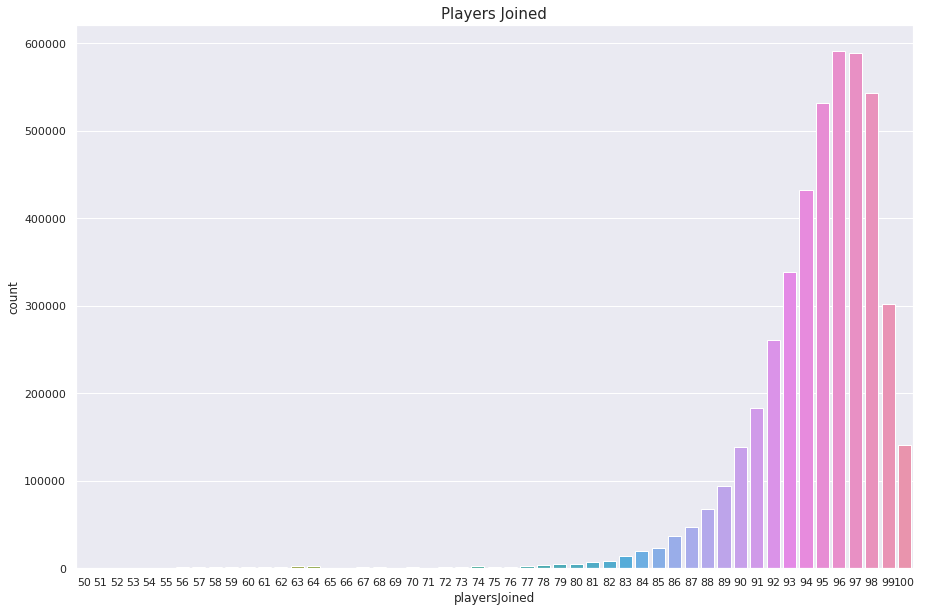

In [133]:
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
data = train.copy()
data = data[data['playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(data['playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

There are a few matches with fewer than 75 players. As you can see most of the matches are nearly packed a have nearly 100 players. It is nevertheless interesting to take these features into our analysis.

## Normalized features
> Now that we have a feature 'playersJoined' we can normalize other features based on the amount of players. First that can be valuable to normalize are:

* kills
* damageDealt
* maxPlace
* matchDuration

Let's try out some things!

In [134]:
train['killsNorm'] = train['kills']*((100-train['playersJoined'])/100 + 1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 + 1)
train['maxPlaceNorm'] = train['maxPlace']*((100-train['playersJoined'])/100 + 1)
train['matchDurationNorm'] = train['matchDuration']*((100-train['playersJoined'])/100 + 1)
to_show = ['Id', 'kills','killsNorm','damageDealt', 'damageDealtNorm', 'maxPlace', 'maxPlaceNorm', 'matchDuration', 'matchDurationNorm']
train[to_show][0:11]

,Id,kills,killsNorm,damageDealt,damageDealtNorm,maxPlace,maxPlaceNorm,matchDuration,matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000000,0.000000,28,29.12,1306,1358.24
1,eef90569b9d03c,0,0.00,91.500000,99.735000,26,28.34,1777,1936.93
2,1eaf90ac73de72,0,0.00,68.000000,69.360000,50,51.00,1318,1344.36
3,4616d365dd2853,0,0.00,32.906250,35.867812,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.03,100.000000,103.000000,97,99.91,1424,1466.72
5,ff79c12f326506,1,1.05,100.000000,105.000000,28,29.40,1395,1464.75
6,95959be0e21ca3,0,0.00,0.000000,0.000000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.539062,8.880625,96,99.84,1967,2045.68
8,1a68204ccf9891,0,0.00,51.593750,53.141562,28,28.84,1375,1416.25
9,e5bb5a43587253,0,0.00,37.281250,38.399687,29,29.87,1930,1987.90


## Heals and Boosts

We create a feature called 'healsandboosts' by adding heals and boosts. (duh!) We are not sure if this has additional predictive value but we can always delete it if the feature importance according to our random forest model is too low.

In [135]:
train['healsandboosts'] = train['heals'] + train['boosts']
train[['heals', 'boosts', 'healsandboosts']].tail()

,heals,boosts,healsandboosts
4446961,0,0,0
4446962,0,1,1
4446963,0,0,0
4446964,2,4,6
4446965,1,2,3


## Killing without moving

We try to identify cheaters by checking if people are getting kills without moving. We first identify the totalDistance travelled by a player and then set a boolean value to True if someone got kills without moving a single inch. We will remove cheaters in our outlier detection section.

In [136]:
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']
train['killsWithoutMoving'] = ((train['kills'] > 0) & (train['totalDistance'] == 0))

**The feature headshot_rate will also help us to catch cheaters.**

In [137]:
train['headshot_rate'] = train['headshotKills'] / train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0)

# Outlier Detection

Some rows in our dataset have really weird characteristics. The players could be cheaters, maniacs or just anomalies. Removing these outliers will most likely improve results.

## Kills without movement

This is perhaps the most obvious sign of cheating in the game. It is already fishy if a player hasn't moved during the whole game, but the player could be AFK and got killed. However, if the player managed to get kills it is most likely a cheater.

In [138]:
display(train[train['killsWithoutMoving'] == True].shape)
train[train['killsWithoutMoving'] == True]

(1535, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.000000,0,0,3,18,0,6,3,23.546875,593,normal-squad-fpp,15,13,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.856934,58,8.52,842.060000,21.30,842.06,3,0.0,True,0.000000
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.500000,0,0,6,33,0,3,1,6.523438,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,0.0,22,0,0.600098,42,4.74,547.470000,17.38,2834.52,6,0.0,True,0.000000
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.000000,0,4,5,3,0,20,6,37.093750,898,normal-solo-fpp,20,15,1500,0,0.0,0,0.0,0,0,0.0,13,0,0.894531,21,35.80,3132.500000,35.80,1607.42,5,0.0,True,0.200000
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.750000,0,0,0,69,1000,1,1,21.546875,799,normal-squad-fpp,19,18,-1,0,0.0,0,0.0,0,0,0.0,7,1500,0.000000,73,1.27,200.342500,24.13,1014.73,0,0.0,True,0.000000
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.000000,0,1,0,37,0,1,1,55.437500,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,0.0,10,0,0.300049,42,1.58,158.000000,17.38,2834.52,0,0.0,True,1.000000
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.000000,4,1,3,7,0,6,2,81.937500,583,normal-squad,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.799805,44,9.36,789.360000,9.36,909.48,3,0.0,True,0.166667
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.000000,0,4,1,7,0,12,5,116.312500,550,normal-squad-fpp,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.600098,48,18.24,1708.480000,9.12,836.00,1,0.0,True,0.333333
24640,aeced11d46de19,d4009ffa95bb4f,73f3ed869c9171,2,0,530.000000,0,2,11,12,0,7,2,84.375000,599,normal-squad-fpp,15,15,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.856934,57,10.01,757.900000,21.45,856.57,11,0.0,True,0.285714
25659,6626c4d47cffa0,ee3fe5c0d917c3,341341834b7941,0,1,128.875000,0,1,6,53,1000,2,1,26.984375,732,normal-squad-fpp,8,8,-1,0,0.0,0,0.0,0,0,0.0,12,1500,0.285645,61,2.78,179.136250,11.12,1017.48,7,0.0,True,0.500000
30079,869331b90bfa3f,869ea3ad036e53,fa373e28ff5062,0,0,85.562500,0,0,0,46,0,1,1,16.437500,715,normal-squad-fpp,15,14,1500,0,0.0,0,0.0,0,0,0.0,4,0,0.856934,53,1.47,125.776875,22.05,1051.05,0,0.0,True,0.000000


In [139]:
# Remove outliers
train.drop(train[train['killsWithoutMoving'] == True].index, inplace=True)

## Anomalies in roadKills**

In [140]:
# Players who got more than 10 roadKills
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,1403,14,13,7.179688,1456,solo,92,80,-1,0,0.005001,14,5.296875,0,0,1277.0,0,1371,0.428711,92,15.12,1345.68,99.36,1572.48,0,1282.0,False,0.000000
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,1497,11,11,0.000000,1946,solo,88,77,-1,0,4120.000000,11,0.000000,0,0,816.5,5,1533,0.471191,88,12.32,1234.24,98.56,2179.52,0,4936.0,False,0.000000
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,1114,20,18,64.312500,1970,solo,38,20,-1,0,2726.000000,18,0.000000,0,0,3150.0,4,1568,1.000000,38,32.40,3359.88,61.56,3191.40,19,5876.0,False,0.050000
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,1520,18,11,341.500000,1925,solo,84,70,-1,0,6812.000000,11,0.000000,0,0,1041.0,10,1606,0.939941,84,20.88,2164.56,97.44,2233.00,10,7852.0,False,0.277778


Note that player c3e444f7d1289d drove 5 meters but killed 14 people with it. Sounds insane doesn't it?

In [141]:
train.drop(train[train['roadKills'] > 10].index, inplace=True)

> ### Anomalies in aim part 1 (More than 45 kills)**

Let's plot the total kills for every player first. It doesn't look like there are too many outliers.

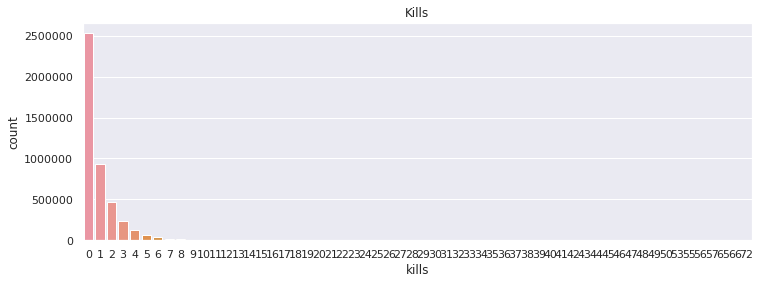

In [142]:
plt.figure(figsize=(12,4))
sns.countplot(data=train, x=train['kills']).set_title('Kills')
plt.show()

In [143]:
# Let's take a closer look
# Players who got more than 30 kills
display(train[train['kills'] > 30].shape)
train[train['kills'] > 30]

(95, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
57978,9d8253e21ccbbd,ef7135ed856cd8,37f05e2a01015f,9,0,3724.0,0,7,0,2,1000,35,3,105.812500,1798,normal-duo-fpp,8,7,-1,0,0.000000,0,0.000000,0,0,48.812500,48,1500,0.856934,16,64.40,6852.16,14.72,3308.32,0,48.812500,False,0.200000
87793,45f76442384931,b3627758941d34,37f05e2a01015f,8,0,3088.0,0,8,27,3,1000,31,3,95.312500,1798,normal-duo-fpp,8,7,-1,0,0.000000,0,0.000000,0,0,780.500000,45,1500,1.000000,16,57.04,5681.92,14.72,3308.32,27,780.500000,False,0.258065
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5480.0,0,12,7,4,0,48,6,81.937500,1798,normal-solo-fpp,11,11,1500,0,0.000000,0,0.000000,0,0,23.703125,61,0,0.700195,11,90.72,10357.20,20.79,3398.22,7,23.703125,False,0.250000
160254,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4032.0,0,40,0,1,1000,42,5,266.250000,844,normal-squad-fpp,8,8,-1,0,0.000000,0,0.000000,1,0,718.500000,16,1500,1.000000,62,57.96,5564.16,11.04,1164.72,0,718.500000,False,0.952381
180189,1355613d43e2d0,f863cd38c61dbf,39c442628f5df5,5,0,3172.0,0,6,15,1,0,35,3,102.500000,1796,normal-solo-fpp,9,6,1500,0,0.000000,0,0.000000,0,0,71.500000,41,0,1.000000,11,66.15,5995.08,17.01,3394.44,15,71.500000,False,0.171429
334400,810f2379261545,7f3e493ee71534,f900de1ec39fa5,20,0,6616.0,0,13,5,1,0,65,7,73.875000,1798,normal-solo-fpp,11,11,1500,0,0.000000,0,0.000000,0,0,1036.000000,60,0,1.000000,11,122.85,12504.24,20.79,3398.22,5,1036.000000,False,0.200000
353128,f3e9746e3ff151,4bc1f00f07b304,a9e84c456cc859,2,0,3834.0,0,9,5,1,0,39,3,264.000000,1795,normal-solo-fpp,13,10,1500,0,0.000000,0,0.000000,0,0,124.187500,42,0,1.000000,13,72.93,7169.58,24.31,3356.65,5,124.187500,False,0.230769
457829,265e23756baa0b,9d94424171c2a1,664dee9ed8f646,3,0,2908.0,0,27,2,1,0,33,4,439.250000,827,normal-squad,5,5,1500,0,0.000000,0,0.000000,1,0,382.500000,15,0,1.000000,38,53.46,4710.96,8.10,1339.74,2,382.500000,False,0.818182
488335,31a0682922ef45,275a27a3ee4cc8,3037f74ef8a3a3,2,0,3056.0,0,9,0,1,1000,33,5,98.000000,892,normal-solo-fpp,18,14,-1,0,0.000000,0,0.000000,0,0,35.312500,31,1500,1.000000,20,59.40,5500.80,32.40,1605.60,0,35.312500,False,0.272727
662650,dd424a8b74bd49,ac9dea6d62f2e6,8a728def0644be,9,0,3454.0,38,9,4,1,1000,34,4,124.000000,1198,normal-squad-fpp,14,14,-1,0,0.000000,0,0.000000,0,0,111.125000,25,1500,0.230835,54,49.64,5042.84,20.44,1749.08,4,111.125000,False,0.264706


In [144]:
# Remove outliers
train.drop(train[train['kills'] > 30].index, inplace=True)

> ### Anomalies in aim part2  (100% headshot rate)**

Again, we first take a look at the whole dataset and create a new feature 'headshot_rate'. We see that the most players score in the 0 to 10% region. However, there are a few anomalies that have a headshot_rate of 100% percent with more than 9 kills!

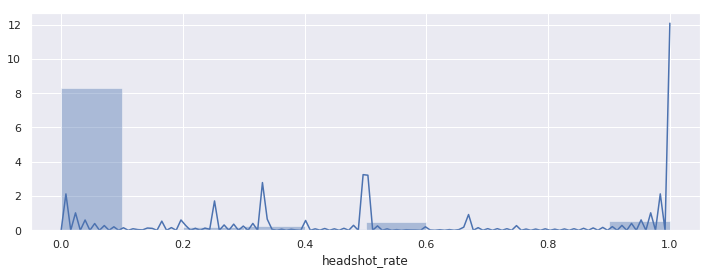

In [145]:
plt.figure(figsize=(12,4))
sns.distplot(train['headshot_rate'], bins=10)
plt.show()

In [146]:
# Players who made a minimum of 10 kills and have a headshot_rate of 100%
display(train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].shape)
train[(train['headshot_rate'] == 1) & (train['kills'] > 9)]

(24, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,0,10,4,159.250,1423,squad-fpp,27,25,1564,1,0.0000,0,0.00,0,0,2940.0,5,0,0.846191,93,10.70,1296.84,28.89,1522.61,3,2940.0,False,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,1424,11,2,633.500,1727,squad,27,26,-1,3,4720.0000,0,0.00,0,0,3422.0,8,1560,1.000000,96,11.44,1684.80,28.08,1796.08,8,8144.0,False,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,1579,13,2,353.750,1255,squad,27,27,-1,0,0.0000,0,0.00,0,0,2104.0,5,1587,1.000000,98,13.26,1392.30,27.54,1280.10,4,2104.0,False,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,1393,10,3,533.000,1838,squad-fpp,28,24,-1,0,5188.0000,0,0.00,2,0,2760.0,7,1519,0.962891,95,10.50,1611.75,29.40,1929.90,8,7948.0,False,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,1543,10,2,277.000,1417,squad,27,26,-1,0,1018.0000,0,0.00,0,0,2458.0,4,1562,1.000000,96,10.40,1409.20,28.08,1473.68,8,3476.0,False,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,0,11,3,485.000,1821,squad-fpp,28,27,1495,0,5248.0000,0,0.00,0,0,2932.0,4,0,1.000000,95,11.55,1278.90,29.40,1912.05,8,8180.0,False,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,1391,10,2,222.000,1246,squad-fpp,27,27,-1,0,409.0000,0,0.00,0,0,2450.0,7,1468,1.000000,97,10.30,1096.95,27.81,1283.38,5,2860.0,False,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,0,12,2,443.000,1730,squad-fpp,28,28,1560,0,2048.0000,0,0.00,0,0,3916.0,5,0,1.000000,93,12.84,1411.33,29.96,1851.10,6,5964.0,False,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,1000,11,3,289.500,1248,duo,46,41,0,1,0.0000,0,0.00,0,0,3108.0,7,1500,1.000000,88,12.32,1288.00,51.52,1397.76,5,3108.0,False,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,0,13,3,95.125,1379,duo-fpp,49,48,1813,0,0.0000,0,140.75,0,0,2340.0,4,0,1.000000,96,13.52,1537.12,50.96,1434.16,12,2480.0,False,1.0


***It is unclear if these players are cheating so we are probably not deleting these players from the dataset. If they are legitimate players, they are probably really crushing the game!***

> ### Anomalies in aim part 3 (Longest kill)**

Most kills are made from a distance of 100 meters or closer. There are however some outliers who make a kill from more than 1km away. This is probably done by cheaters.

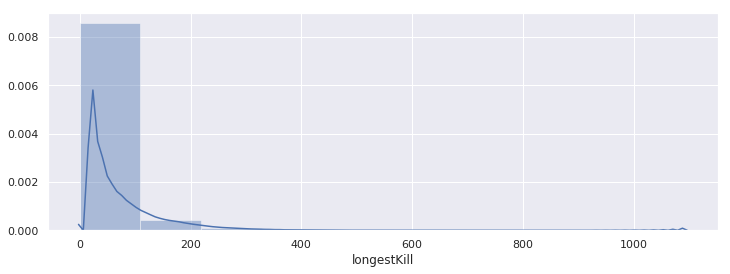

In [147]:
plt.figure(figsize=(12,4))
sns.distplot(train['longestKill'], bins=10)
plt.show()

In [148]:
#Let's take a look at the players who make these shots.
display(train[train['longestKill'] >= 1000].shape)
train[train['longestKill'] >= 1000]

(21, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
195021,f141f7e776138b,a0fa42bf37e9f0,0b4c9543bc9199,1,4,784.00,5,4,5,4,1195,4,2,1000.0,2190,duo,34,31,-1,0,6248.000,0,0.0000,0,0,3678.000000,5,1523,0.848633,66,5.36,1050.5600,45.56,2934.60,9,9928.000000,False,1.000000
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,784.00,5,1,1,5,0,4,3,1000.0,1864,squad,27,27,1482,0,723.000,0,0.0000,0,1,3052.000000,9,0,0.923340,88,4.48,878.0800,30.24,2087.68,4,3776.000000,False,0.250000
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.00,8,5,7,18,1000,11,2,1004.0,1308,normal-duo-fpp,14,13,-1,1,0.000,0,0.0000,0,0,48.875000,38,1500,0.538574,29,18.81,2195.6400,23.94,2236.68,7,48.875000,False,0.454545
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.00,0,0,0,9,0,10,2,1026.0,698,normal-squad-fpp,13,13,1500,0,1717.000,0,0.0000,0,0,1264.000000,26,0,1.000000,51,14.90,1531.7200,19.37,1040.02,0,2980.000000,False,0.000000
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.00,17,5,0,3,1000,16,4,1000.0,1091,normal-squad-fpp,6,6,-1,4,0.000,0,0.0000,0,0,29.203125,30,1500,0.600098,41,25.44,2241.9000,9.54,1734.69,0,29.203125,False,0.312500
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.75,0,0,0,51,0,1,1,1075.0,471,normal-squad-fpp,8,8,1500,0,2084.000,0,0.0000,0,0,1074.000000,22,0,0.000000,61,1.39,273.4825,11.12,654.69,0,3158.000000,False,0.000000
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.00,11,5,0,5,0,10,3,1094.0,1021,normal-squad-fpp,12,12,1500,0,0.000,0,0.0000,0,0,569.500000,18,0,0.909180,86,11.40,1153.6800,13.68,1163.94,0,569.500000,False,0.500000
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.25,0,0,2,45,1000,3,1,1037.0,581,normal-squad-fpp,8,7,-1,0,0.000,0,0.0000,0,0,832.500000,9,1500,0.285645,58,4.26,467.5350,11.36,825.02,3,832.500000,False,0.000000
1209416,528659ff1c1aec,7d1ba83423551d,ea9386587d5888,0,6,1640.00,0,7,0,1,1000,15,2,1001.0,1235,solo,52,51,-1,0,0.000,0,0.0000,0,0,2848.000000,4,1500,0.941406,52,22.20,2427.2000,76.96,1827.80,6,2848.000000,False,0.466667
1642712,91966848e08e2f,0ee4fbd27657c9,17dea22cefe62a,3,2,2104.00,0,4,11,11,0,23,2,1005.0,1798,normal-duo-fpp,15,12,1500,0,0.000,0,0.0000,0,0,235.250000,41,0,0.500000,28,39.56,3618.8800,25.80,3092.56,13,235.250000,False,0.173913


**There is something fishy going on with these players. We are probably better off removing them from our dataset.**

In [149]:
# Remove outliers
train.drop(train[train['longestKill'] >= 1000].index, inplace=True)

> ### Anomalies in travelling (rideDistance, walkDistance and swimDistance)**

Let's check out anomalies in Distance travelled.

In [150]:
train[['walkDistance', 'rideDistance', 'swimDistance', 'totalDistance']].describe()

,walkDistance,rideDistance,swimDistance,totalDistance
count,4445310.000,4.445310e+06,4445310.0,4445310.000
mean,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN
min,0.000,0.000000e+00,0.0,0.000
25%,155.375,0.000000e+00,0.0,158.375
50%,686.500,0.000000e+00,0.0,789.500
75%,1977.000,2.603760e-01,0.0,2728.000
max,25776.000,4.070400e+04,3824.0,41280.000


> ## walkDistance

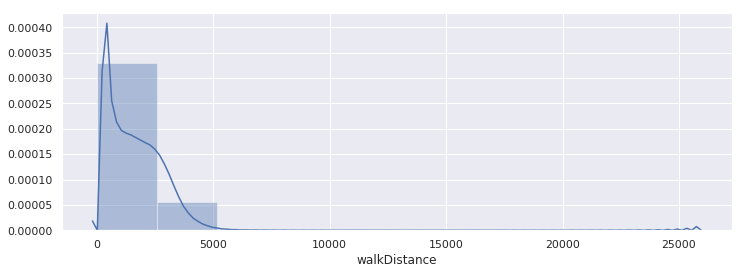

In [151]:
plt.figure(figsize=(12,4))
sns.distplot(train['walkDistance'], bins=10)
plt.show()


In [152]:
# walkDistance anomalies
display(train[train['walkDistance'] >= 10000].shape)
train[train['walkDistance'] >= 10000]

(219, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.000000,0,0,0,44,0,0,0,0.000000,1906,solo,99,93,1517,0,0.421143,0,9.882812,0,0,13528.0,7,0,0.816406,99,0.00,0.000000,99.99,1925.06,1,13536.0,False,0.000000
34344,5a591ecc957393,6717370b51c247,a15d93e7165b05,0,3,23.218750,0,0,1,34,1256,0,0,0.000000,1977,squad-fpp,20,20,-1,0,0.037292,0,40.875000,0,0,10032.0,7,1533,0.947266,65,0.00,31.345313,27.00,2668.95,4,10072.0,False,0.000000
49312,582685f487f0b4,338112cd12f1e7,d0afbf5c3a6dc9,0,4,117.187500,1,0,1,24,0,1,1,6.824219,2192,duo-fpp,47,46,1507,0,0.008797,0,36.750000,0,0,12408.0,3,0,0.913086,94,1.06,124.218750,49.82,2323.52,5,12448.0,False,0.000000
68590,8c0d9dd0b4463c,c963553dc937e9,926681ea721a47,0,1,32.343750,0,0,1,46,1378,0,0,0.000000,1836,duo-fpp,49,47,-1,0,848.000000,0,45.812500,0,0,11592.0,3,1563,0.833496,96,0.00,33.637500,50.96,1909.44,2,12488.0,False,0.000000
94400,d441bebd01db61,7e179b3366adb8,923b57b8b834cc,1,1,73.062500,0,0,3,27,1000,0,0,0.000000,1806,solo,73,64,-1,0,1005.000000,0,45.625000,0,0,10440.0,6,1488,0.819336,73,0.00,92.789375,92.71,2293.62,4,11496.0,False,0.000000
125103,db5a0cdc969dcb,50cc466757950e,c306a9745c4c1d,0,4,37.718750,0,0,7,47,1000,0,0,0.000000,1957,solo,95,93,-1,0,0.037811,0,38.750000,0,0,12792.0,5,1500,0.733887,95,0.00,39.604688,99.75,2054.85,11,12832.0,False,0.000000
136421,955e60b09a96b1,30df08fe22a901,8669d01725f135,0,1,0.000000,0,0,1,46,0,0,0,0.000000,1973,duo-fpp,47,43,1590,0,1823.000000,0,30.812500,0,0,10368.0,3,0,0.695801,94,0.00,0.000000,49.82,2091.38,2,12224.0,False,0.000000
136476,0d75d05b5c988c,3da040ce77cd0b,65bc5211a569dd,0,3,0.000000,0,0,0,41,1370,0,0,0.000000,1861,solo-fpp,91,89,-1,0,4580.000000,0,197.250000,0,0,10144.0,5,1772,0.933105,91,0.00,0.000000,99.19,2028.49,3,14920.0,False,0.000000
154080,7e8a71d23381cd,e2c9f4f92840b2,a721de1aa05408,0,3,0.000000,0,0,13,46,0,0,0,0.000000,1923,solo-fpp,94,89,1476,0,2400.000000,0,16.703125,0,0,10224.0,4,0,0.860352,94,0.00,0.000000,99.64,2038.38,16,12640.0,False,0.000000
154128,32fdde4c716787,390ae9a51c11b8,82610ed1b4d033,0,4,52.156250,0,0,7,25,0,1,1,28.312500,1836,duo-fpp,48,47,1451,1,0.031403,0,29.828125,0,0,10864.0,6,0,0.893555,95,1.05,54.764063,50.40,1927.80,11,10896.0,False,0.000000


In [153]:
# Remove outliers
train.drop(train[train['walkDistance'] >= 10000].index, inplace=True)

> ## Ride Distance

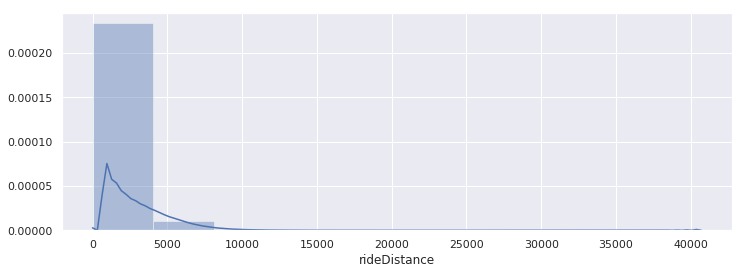

In [154]:
plt.figure(figsize=(12,4))
sns.distplot(train['rideDistance'], bins=10)
plt.show()

In [155]:
# rideDistance anomalies
train[train['rideDistance'] >= 20000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
28588,6260f7c49dc16f,b24589f02eedd7,6ebea3b4f55b4a,0,0,99.187500,0,0,1,30,0,1,1,5.417969,1894,solo,96,89,1642,0,25936.0,0,0.000000,0,0,376.500000,6,0,0.642090,96,1.04,103.155000,99.84,1969.76,1,26320.0,False,0.000000
63015,adb7dae4d0c10a,8ede98a241f30a,8b36eac66378e4,0,0,0.000000,0,0,0,55,0,0,0,0.000000,1891,solo,94,88,1529,0,21888.0,0,0.000000,0,0,185.375000,0,0,0.537598,94,0.00,0.000000,99.64,2004.46,0,22080.0,False,0.000000
70507,ca6fa339064d67,f7bb2e30c3461f,3bfd8d66edbeff,0,0,100.000000,0,0,0,26,0,1,1,3.923828,1928,solo,99,95,1512,0,28448.0,1,0.000000,0,0,467.500000,3,0,0.887695,99,1.01,101.000000,99.99,1947.28,0,28912.0,False,0.000000
72763,198e5894e68ff4,ccf47c82abb11f,d92bf8e696b61d,0,0,0.000000,0,0,0,46,0,0,0,0.000000,1807,solo-fpp,97,92,1534,0,20512.0,0,0.000000,1,0,687.000000,9,0,0.791504,97,0.00,0.000000,99.91,1861.21,0,21200.0,False,0.000000
95276,c3fabfce7589ae,15529e25aa4a74,d055504340e5f4,0,7,778.000000,0,1,2,2,0,7,2,162.375000,1874,solo,94,88,1495,0,25808.0,2,0.000000,0,0,923.000000,6,0,0.978516,94,7.42,824.680000,99.64,1986.44,9,26736.0,False,0.142857
140097,9944fbbea2b91e,18b4d5f4bb1906,d9d4a3e50cae75,1,0,12.546875,0,0,0,53,1270,0,0,0.000000,1899,solo-fpp,89,88,-1,0,21232.0,0,0.000000,0,0,63.218750,0,1514,0.500000,89,0.00,13.927031,98.79,2107.89,0,21296.0,False,0.000000
297186,88904c200175b6,012a61a01e146e,7a270c25e9b70c,0,1,0.000000,0,0,1,47,0,0,0,0.000000,1919,duo-fpp,48,47,1522,1,28976.0,0,0.000000,0,0,297.250000,3,0,0.744629,96,0.00,0.000000,49.92,1995.76,2,29280.0,False,0.000000
371098,f7071357f6b762,f3ee20821f4627,ac47c86bf385bf,0,0,72.937500,1,0,0,45,0,0,0,0.000000,1878,duo-fpp,49,46,1502,0,21696.0,0,0.000000,0,0,242.125000,4,0,0.687500,96,0.00,75.855000,50.96,1953.12,0,21936.0,False,0.000000
403647,c65da7b3fceef5,814d1b3736e276,ff9f570b555d48,0,2,0.000000,0,0,3,54,0,0,0,0.000000,1821,duo-fpp,47,46,1527,0,20608.0,0,0.000000,0,0,598.000000,1,0,0.673828,94,0.00,0.000000,49.82,1930.26,5,21200.0,False,0.000000
426708,149e224a2330ae,6d8cb80b3de8ff,f8b8e2643f60ee,0,2,0.000000,0,0,2,43,1120,0,0,0.000000,2007,solo,83,83,-1,0,31968.0,0,0.000000,0,0,402.000000,3,1449,0.816895,83,0.00,0.000000,97.11,2348.19,4,32368.0,False,0.000000


In [156]:
# Remove outliers
train.drop(train[train['rideDistance'] >= 20000].index, inplace=True)

> ## swimDistance

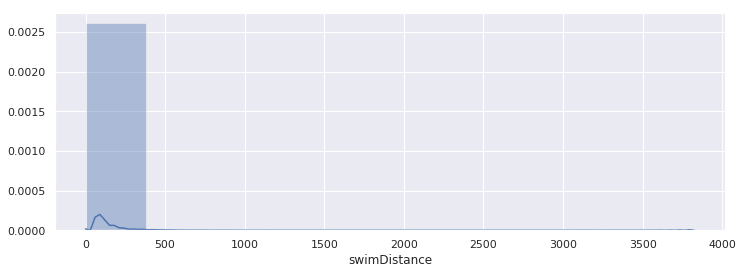

In [157]:
#swimDistance
plt.figure(figsize=(12,4))
sns.distplot(train['swimDistance'], bins=10)
plt.show()

In [158]:
train[train['swimDistance'] >= 2000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
177973,c2e9e5631f4e54,23213058f83abe,f01eb1073ef377,0,5,78.12500,1,0,1,47,1058,0,0,0.000000,1399,duo-fpp,50,46,-1,0,0.0,0,2296.0,0,0,1002.000000,4,1466,0.958984,98,0.00,79.68750,51.00,1426.98,6,3298.0,False,0.000000
274258,ba5e3dfb5a0fa0,383db055216ec2,d6e13468e28ab4,0,4,53.31250,0,0,16,39,0,0,0,0.000000,2188,squad,26,25,1584,0,5688.0,0,2148.0,0,0,2276.000000,5,0,0.959961,94,0.00,56.51125,27.56,2319.28,20,10112.0,False,0.000000
1005337,d50c9d0e65fe2a,4996575c11abcb,668402592429f8,0,1,503.00000,4,3,1,6,1103,3,1,868.500000,1897,squad,26,25,-1,0,3332.0,0,2718.0,0,0,4692.000000,5,1516,1.000000,88,3.36,563.36000,29.12,2124.64,2,10744.0,False,1.000000
1195818,f811de9de80b70,d08ddf7beb6252,8a48703ab52ec8,0,7,352.25000,3,1,6,4,1039,5,1,64.500000,1396,duo-fpp,49,48,-1,0,0.0,0,2668.0,0,0,415.000000,10,1499,1.000000,98,5.10,359.29500,49.98,1423.92,13,3084.0,False,0.200000
1227362,a33e917875c80e,5b72674b42712b,5fb0d8b1fc16cf,0,1,589.00000,3,1,1,46,0,2,1,48.218750,1021,normal-squad-fpp,12,12,1500,0,0.0,0,3824.0,0,0,995.500000,9,0,1.000000,86,2.28,671.46000,13.68,1163.94,2,4820.0,False,0.500000
1889163,bd8cc3083a9923,1d5d17140d6fa4,8e2e6022d6e5c8,0,0,0.00000,0,0,0,47,0,0,0,0.000000,1387,squad-fpp,25,23,1327,0,864.0,0,2484.0,0,0,1966.000000,3,0,0.583496,87,0.00,0.00000,28.25,1567.31,0,5312.0,False,0.000000
2065940,312ccbb27b99aa,47c7f4d69e2fb1,b4b11756321f3a,1,3,49.59375,0,0,5,48,1097,0,0,0.000000,1379,duo-fpp,48,46,0,1,2088.0,0,3514.0,0,0,4296.000000,8,1492,0.851074,96,0.00,51.57750,49.92,1434.16,8,9896.0,False,0.000000
2327586,8773d0687c6aae,b17f46f9f6666c,56ee5897512c86,3,1,474.50000,2,0,0,7,0,3,2,30.015625,1210,squad-fpp,27,24,1516,0,0.0,0,2388.0,0,0,7.546875,6,0,1.000000,91,3.27,517.20500,29.43,1318.90,1,2396.0,False,0.000000
2784855,a8653b87e83892,383db055216ec2,d6e13468e28ab4,1,4,844.00000,5,5,2,2,0,7,1,697.000000,2188,squad,26,25,1628,1,3032.0,0,2206.0,0,0,4688.000000,4,0,0.959961,94,7.42,894.64000,27.56,2319.28,6,9928.0,False,0.714286
3359439,3713b36e1ba9e1,1f7aed9240864a,584447ed875c85,0,0,0.00000,0,0,0,77,1056,0,0,0.000000,1372,squad-fpp,29,29,-1,0,0.0,0,2338.0,0,0,1750.000000,0,1518,0.214355,96,0.00,0.00000,30.16,1426.88,0,4088.0,False,0.000000


In [159]:
# Remove outliers
train.drop(train[train['swimDistance'] >= 2000].index, inplace=True)

> ## Anomalies in supplies (weaponsAcquired)

Most people acquire between 0 and 10 weapons in a game, but you also see some people acquire more than 80 weapons! Let's check these guys out.

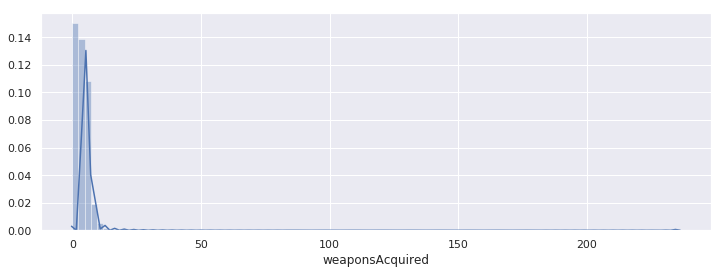

In [160]:
plt.figure(figsize=(12,4))
sns.distplot(train['weaponsAcquired'], bins=100)
plt.show()

In [161]:
train[train['weaponsAcquired'] >= 80]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.125000,0,0,0,44,1279,0,0,0.00000,1901,duo,46,45,-1,0,1880.00,0,0.00000,0,0,1307.00,128,1577,0.710938,91,0.00,73.166250,50.14,2072.09,0,3188.00,False,0.000000
588387,c58e3e0c2ba678,3d3e6100c07ff0,d04dbb98249f76,0,1,175.250000,1,0,2,48,0,0,0,0.00000,1372,squad,29,29,1473,0,0.00,0,0.00000,0,0,1687.00,80,0,0.750000,98,0.00,178.755000,29.58,1399.44,3,1687.00,False,0.000000
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,0,100.000000,0,0,0,24,0,1,1,110.62500,1840,squad-fpp,29,28,1528,0,2852.00,0,47.21875,0,0,2400.00,102,0,0.893066,97,1.03,103.000000,29.87,1895.20,0,5300.00,False,0.000000
1449293,db54cf45b9ed1c,898fccaeeb041d,484b4ae51fe80f,0,0,0.000000,0,0,0,54,0,0,0,0.00000,1330,squad-fpp,26,23,1442,0,0.00,0,0.00000,0,0,653.00,95,0,0.560059,80,0.00,0.000000,31.20,1596.00,0,653.00,False,0.000000
1592744,634a224c53444e,75fa7591d1538c,f900de1ec39fa5,9,0,1726.000000,0,3,0,9,0,23,2,48.40625,1798,normal-solo-fpp,11,11,1500,0,1908.00,0,0.00000,0,0,981.00,94,0,0.199951,11,43.47,3262.140000,20.79,3398.22,0,2888.00,False,0.130435
1834515,e927e9020f7e0d,60d6b714a7308f,8e265af296007b,1,1,26.453125,0,0,1,51,0,0,0,0.00000,1431,squad,26,26,1487,1,0.00,0,0.00000,0,0,2836.00,96,0,0.919922,95,0.00,27.775781,27.30,1502.55,2,2836.00,False,0.000000
2373240,a8c150d5d3d3e2,6e1c8c5f91e060,f900de1ec39fa5,12,0,1746.000000,0,1,1,11,0,16,2,38.50000,1798,normal-solo-fpp,11,11,1500,0,0.00,0,0.00000,0,0,276.00,96,0,0.000000,11,30.24,3299.940000,20.79,3398.22,1,276.00,False,0.062500
2442962,438cabaa5dfbdd,596c155c524725,8e0bbeec19a929,0,0,0.000000,0,0,0,56,0,0,0,0.00000,1173,squad-fpp,27,26,1412,0,0.00,0,0.00000,0,0,807.50,95,0,0.500000,91,0.00,0.000000,29.43,1278.57,0,807.50,False,0.000000
2743408,afcb46681b909f,3715298b7eea9c,4dd4d42772464f,0,4,186.875000,2,0,2,18,1288,2,2,33.43750,1511,duo,45,45,-1,0,1675.00,0,0.00000,1,0,1643.00,167,1452,0.795410,90,2.20,205.562500,49.50,1662.10,6,3318.00,False,0.000000
2749693,940b52bf12805a,4757d102ca4fbf,7ecae2cedc064f,1,3,379.000000,2,0,5,7,1791,3,1,140.50000,1400,squad-fpp,27,26,-1,0,303.75,0,0.00000,0,0,3338.00,177,1711,0.884766,98,3.06,386.580000,27.54,1428.00,8,3642.00,False,0.000000


In [162]:
# Remove outliers
train.drop(train[train['weaponsAcquired'] >= 80].index, inplace=True)

**We should probably remove these outliers from our model.**
Note that player 3f2bcf53b108c4 acquired 236 weapons in one game!

> ## Anomalies in supplies part 2 (heals)**

Most players us 5 healing items or less. We can again recognize some weird anomalies

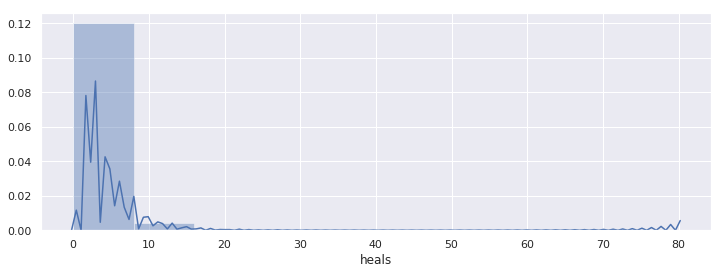

In [163]:
plt.figure(figsize=(12,4))
sns.distplot(train['heals'], bins=10)
plt.show()

In [164]:
display(train[train['heals'] >= 40].shape)
train[train['heals'] >= 40]

(135, 38)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate
18405,63ab976895d860,927eeba5614c4f,69473402649f11,0,2,0.000000,0,0,47,43,0,0,0,0.000000,1797,solo-fpp,96,92,1527,0,5468.00,0,0.000000,0,0,1387.00,6,0,0.937012,96,0.00,0.000000,99.84,1868.88,49,6856.00,False,0.000000
54463,069ddee7c9d26a,58ab5a1ce8e06f,942416b6caf21e,1,4,182.000000,0,1,43,21,0,1,1,5.515625,1532,squad,27,27,1500,0,0.00,0,292.500000,0,0,2792.00,7,0,0.961426,93,1.07,194.740000,28.89,1639.24,47,3084.00,False,1.000000
126439,c45bd6917146e2,81ab9f863957cb,4335664c6716fa,0,2,0.000000,0,0,52,49,1331,0,0,0.000000,1374,solo-fpp,97,96,-1,0,0.00,0,3.443359,0,0,1340.00,3,1543,0.833496,97,0.00,0.000000,99.91,1415.22,54,1343.00,False,0.000000
259351,86910c38335c2f,2738398928d28c,7d2911e944bfaa,0,10,0.000000,0,0,42,45,0,0,0,0.000000,1769,solo-fpp,97,94,1563,0,5936.00,0,0.000000,0,0,1510.00,6,0,0.864746,97,0.00,0.000000,99.91,1822.07,52,7448.00,False,0.000000
268747,a007734fbc6ebf,5bf702dfa1e5d4,ad6b5669d33a2c,0,5,0.000000,0,0,48,43,0,0,0,0.000000,1878,solo-fpp,93,93,1500,0,3848.00,0,0.000000,0,0,1968.00,9,0,0.836914,93,0.00,0.000000,99.51,2009.46,53,5816.00,False,0.000000
269098,a0891dbc2950ea,dde848d90491ba,b4fd3348551b73,0,2,0.000000,0,0,42,44,1359,0,0,0.000000,1295,squad-fpp,28,28,-1,0,0.00,0,0.000000,0,0,2440.00,2,1511,0.925781,97,0.00,0.000000,28.84,1333.85,44,2440.00,False,0.000000
284195,91a2fb00455eb3,f639b09774c5b1,65b73c71653822,0,3,123.000000,0,0,40,52,0,0,0,0.000000,1965,squad-fpp,30,29,1506,0,2596.00,0,0.000000,0,0,2252.00,8,0,0.827637,99,0.00,124.230000,30.30,1984.65,43,4848.00,False,0.000000
300204,1f4f2efc86bfcb,3d668492d1fca9,d3638466a43d38,0,6,175.000000,2,1,47,25,1254,1,1,33.312500,1358,squad-fpp,32,31,-1,0,487.50,0,0.000000,0,0,2928.00,3,1562,0.935547,95,1.05,183.750000,33.60,1425.90,53,3416.00,False,1.000000
349908,7725ad71ad2ff7,4b2a7cf86d1546,cfa2775c9ef944,3,0,2348.000000,0,8,41,9,1000,27,3,87.187500,1797,normal-solo-fpp,37,22,-1,0,0.00,0,0.000000,0,0,268.75,33,1500,0.888672,41,42.93,3733.320000,58.83,2857.23,41,268.75,False,0.296296
375156,d64866c78ebcb0,aa0f089ae6430c,4dbc4ebba33ec6,0,7,278.500000,3,1,44,3,1034,4,2,35.406250,1807,squad,28,25,-1,1,2438.00,0,0.000000,0,0,2488.00,6,1517,0.962891,94,4.24,295.210000,29.68,1915.42,51,4928.00,False,0.250000


In [165]:
# Remove outliers
train.drop(train[train['heals'] >= 40].index, inplace=True)

> ## Outlier conclusions

We removed about 2000 players from our dataset.

In [166]:
train.shape

(4444775, 38)

> # Prepararation for Machine Learning

In [167]:
# We delete the matchType, Id, groupId and matchId columns here for convenience
# We will come back to this later.
train = train.drop(columns = ['matchType', 'Id', 'groupId', 'matchId'])

In [168]:
# Take sample for debugging and exploration
sample = 500000
df_sample = train.sample(sample)

In [169]:
df = df_sample.drop(columns = ['winPlacePerc']) #all columns except target
y = df_sample['winPlacePerc'] # Only target variable

> ## Split target variable, validation data, etc.

In [170]:
def split_vals(a, n : int): 
    return a[:n].copy(), a[n:].copy()
val_perc = 0.12 # % to use for validation set
n_valid = int(val_perc * sample) 
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_sample, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (440000, 33) Sample target shape:  (440000,) Sample validation shape:  (60000, 33)


In [171]:
#Set metrics (MAE)
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error

# Function to print the MAE score
def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_valid), y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [172]:
# Train basic model
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m1.fit(X_train, y_train)
print_score(m1)

['mae train: ', 0.03912965359041787, 'mae val: ', 0.06201770476438337]


In [173]:
# What are the most predictive features according to our basic random forest model
fi = rf_feat_importance(m1, df); fi[:10]

,cols,imp
21,walkDistance,0.221179
6,killPlace,0.183444
30,totalDistance,0.157971
29,healsandboosts,0.107819
22,weaponsAcquired,0.072291
1,boosts,0.042202
5,heals,0.037486
10,longestKill,0.030271
26,damageDealtNorm,0.017321
16,rideDistance,0.015620


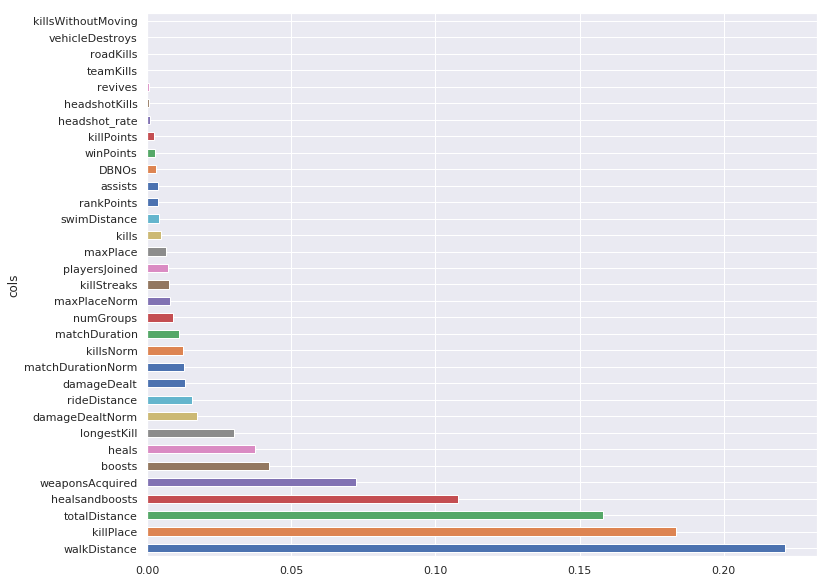

In [174]:
# Plot a feature importance graph for all features
plot1 = fi.plot('cols', 'imp', figsize=(12,10), legend=False, kind = 'barh')
plot1

# Save figure
#fig = plot1.get_figure()
#fig.savefig("Feature_importances(AllFeatures).png")

In [175]:
#Keep only significant features
to_keep = fi[fi.imp>0.005].cols
print('Significant features: ', len(to_keep))
to_keep

Significant features:  20


21         walkDistance
6             killPlace
30        totalDistance
29       healsandboosts
22      weaponsAcquired
1                boosts
5                 heals
10          longestKill
26      damageDealtNorm
16         rideDistance
2           damageDealt
28    matchDurationNorm
25            killsNorm
11        matchDuration
13            numGroups
27         maxPlaceNorm
9           killStreaks
24        playersJoined
12             maxPlace
8                 kills
Name: cols, dtype: object

In [176]:
# Make a DataFrame with only significant features
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

## Second Random Forest Model**

In [177]:
# Train model on top features
m2 = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m2.fit(X_train, y_train)
print_score(m2)

['mae train: ', 0.03712099835066748, 'mae val: ', 0.06025351357103874]


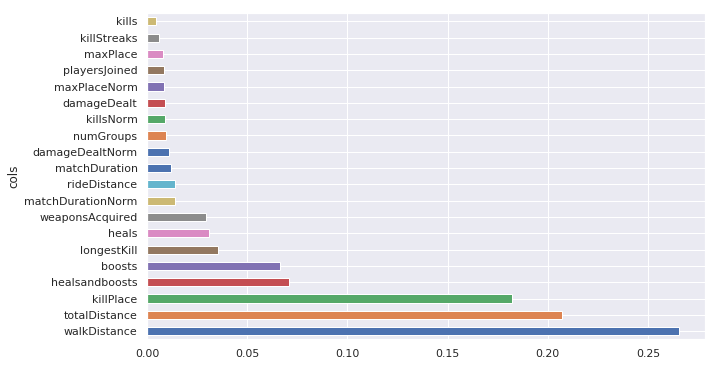

In [178]:
# Get feature importances of our top features
fi_to_keep = rf_feat_importance(m2, df_keep)
plot2 = fi_to_keep.plot('cols', 'imp', figsize=(10,6), legend=False, kind = 'barh')
plot2

# save figure
#fig = plot2.get_figure()
#fig.savefig("Feature_importances(TopFeatures).png")

[]

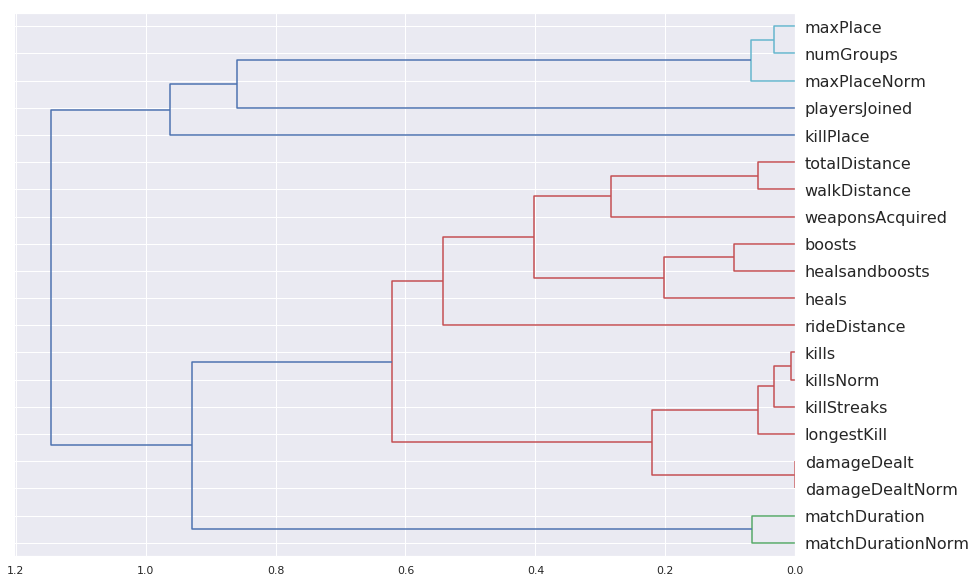

In [179]:
# Create a Dendrogram to view highly correlated features
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(14,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.plot()

# For saving figure
#plt.savefig('Dendrogram.png')

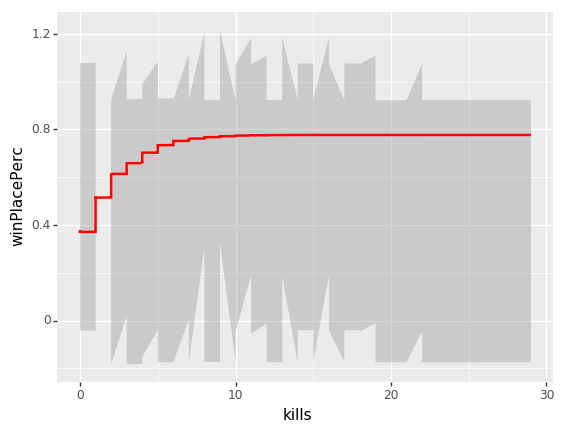

<ggplot: (8782751819994)>

In [180]:
# Plot the predictive quality of kills 
x_all = get_sample(train, 100000)
ggplot(x_all, aes('kills','winPlacePerc'))+stat_smooth(se=True, colour='red', method='mavg')

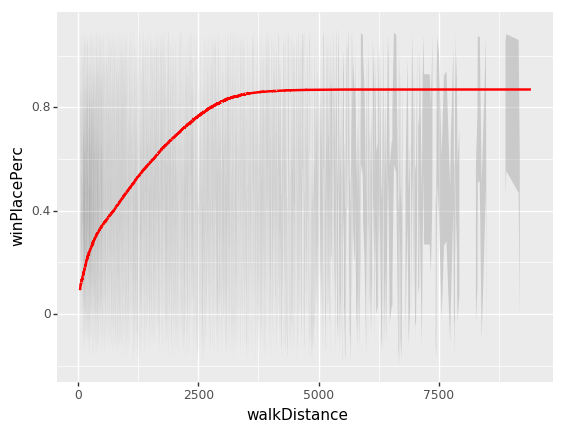

<ggplot: (8782751761693)>

In [181]:
# Plot the predictive quality of walkDistance
x_all = get_sample(train, 100000)
ggplot(x_all, aes('walkDistance','winPlacePerc'))+stat_smooth(se=True, colour='red', method='mavg')

## Final Random Forest Model**

In [182]:
# Prepare data
val_perc_full = 0.12 # % to use for validation set
n_valid_full = int(val_perc_full * len(train)) 
n_trn_full = len(train)-n_valid_full
df_full = train.drop(columns = ['winPlacePerc']) # all columns except target
y = train['winPlacePerc'] # target variable
df_full = df_full[to_keep] # Keep only relevant features
X_train, X_valid = split_vals(df_full, n_trn_full)
y_train, y_valid = split_vals(y, n_trn_full)

print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (3911402, 20) Sample target shape:  (3911402,) Sample validation shape:  (533373, 20)


In [186]:
m3 = RandomForestRegressor(n_estimators=60, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
m3.fit(X_train, y_train)
print_score(m3)

['mae train: ', 0.03102605429293436, 'mae val: ', 0.05606793603264147]


In [187]:
test = pd.read_csv('../input/test_V2.csv')

> ## Normalising test variables as well**

In [188]:
test['headshot_rate'] = test['headshotKills'] / test['kills']
test['headshot_rate'] = test['headshot_rate'].fillna(0)
test['totalDistance'] = test['rideDistance'] + test['walkDistance'] + test['swimDistance']
test['playersJoined'] = test.groupby('matchId')['matchId'].transform('count')
test['killsNorm'] = test['kills']*((100-test['playersJoined'])/100 + 1)
test['damageDealtNorm'] = test['damageDealt']*((100-test['playersJoined'])/100 + 1)
test['maxPlaceNorm'] = test['maxPlace']*((100-train['playersJoined'])/100 + 1)
test['matchDurationNorm'] = test['matchDuration']*((100-test['playersJoined'])/100 + 1)
test['healsandboosts'] = test['heals'] + test['boosts']
test['killsWithoutMoving'] = ((test['kills'] > 0) & (test['totalDistance'] == 0))

# Remove irrelevant features from the test set
test_pred = test[to_keep].copy()

# Fill NaN with 0 (temporary)
test_pred.fillna(0, inplace=True)
test_pred.head()

,walkDistance,killPlace,totalDistance,healsandboosts,weaponsAcquired,boosts,heals,longestKill,damageDealtNorm,rideDistance,damageDealt,matchDurationNorm,killsNorm,matchDuration,numGroups,maxPlaceNorm,killStreaks,playersJoined,maxPlace,kills
0,588.0,73,588.0,0,1,0,0,0.00,55.5768,0.0,51.46,2034.72,0.00,1884,28,29.12,0,92,28,0
1,2017.0,11,6686.0,6,6,4,2,361.90,186.2640,4669.0,179.10,1883.44,2.08,1811,47,52.32,1,96,48,2
2,787.8,49,787.8,4,4,0,4,0.00,24.8040,0.0,23.40,1900.58,0.00,1793,27,28.56,0,94,28,0
3,1812.0,54,1812.0,0,3,0,0,0.00,72.7272,0.0,65.52,2035.74,0.00,1834,44,49.05,0,89,45,0
4,2963.0,7,2963.0,5,4,4,1,60.06,346.7100,0.0,330.20,1392.30,3.15,1326,27,28.84,1,95,28,3


In [189]:
predictions = np.clip(a = m3.predict(test_pred), a_min = 0.0, a_max = 1.0)
pred_df = pd.DataFrame({'Id' : test['Id'], 'winPlacePerc' : predictions})
# Create submission file
pred_df.to_csv("submission.csv", index=False)

In [190]:
print('Head of submission: ')
display(pred_df.head())
print('Tail of submission: ')
display(pred_df.tail())

Head of submission: 


,Id,winPlacePerc
0,9329eb41e215eb,0.211912
1,639bd0dcd7bda8,0.924411
2,63d5c8ef8dfe91,0.697102
3,cf5b81422591d1,0.538834
4,ee6a295187ba21,0.924777


Tail of submission: 


,Id,winPlacePerc
1934169,a316c3a13887d5,0.712696
1934170,5312146b27d875,0.409192
1934171,fc8818b5b32ad3,0.881865
1934172,a0f91e35f8458f,0.843456
1934173,3696fc9f3a42b2,0.042028
